In [ ]:
#!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip

In [ ]:
'''import tarfile

#simple function to extract the train data
#tar_file : the path to the .tar file
#path : the path where it will be extracted
def extract(tar_file, path):
    opened_tar = tarfile.open(tar_file)

    if tarfile.is_tarfile(tar_file):
        opened_tar.extractall(path)
    else:
        print("The tar file you entered is not a tar file")
extract('/content/cc.ar.300.vec.gz', '/content')'''

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#For Pre-Processing
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
import os, re, csv, math, codecs


# For Training
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

# For array, dataset, and visualizing
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")
np.random.seed(0)

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(nltk.corpus.stopwords.words("arabic"))
stop_words.update(['.', ',', '"', "'", ':', ';', '(', ')', '[', ']', '{', '}'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
print('loading word embeddings...')

embeddings_index = {}
f = codecs.open('/content/drive/MyDrive/vectors.txt', encoding='utf-8')

for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('found %s word vectors' % len(embeddings_index))

loading word embeddings...


1538616it [02:57, 8650.93it/s] 

found 1538616 word vectors


In [ ]:
from sklearn.model_selection import train_test_split
df_Spam = pd.read_excel("SpamTweets_S.xlsx")
df_Ham = pd.read_excel("HamTweets_S.xlsx")
df_Spam = df_Spam[['Cleaned Text','Label']]
df_Ham = df_Ham[['Cleaned Text','Label']]
df_Spam = df_Spam.drop_duplicates(subset="Cleaned Text")
df_Ham = df_Ham.drop_duplicates(subset="Cleaned Text")
df = pd.concat([df_Spam, df_Ham])

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df.Label.values)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


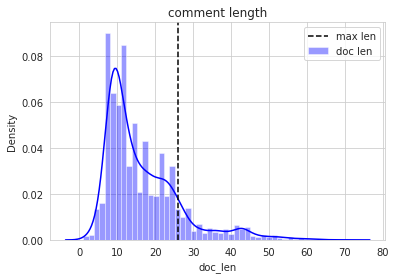

In [ ]:
label_names = ["Label"]
y_train = train_df[label_names].values

train_df['doc_len'] = train_df['Cleaned Text'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)

sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [ ]:
from sklearn.utils import shuffle
from keras.utils import pad_sequences

raw_docs_train = train_df['Cleaned Text'].tolist()
raw_docs_test = test_df['Cleaned Text'].tolist()
num_classes = len(label_names)

print("pre-processing train data...")

processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = word_tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = keras.utils.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = keras.utils.pad_sequences(word_seq_test, maxlen=max_seq_len)

pre-processing train data...


100%|██████████| 2653/2653 [00:00<00:00, 8357.76it/s]


tokenizing input data...
dictionary size:  30973


In [ ]:
#training params
batch_size = 256
num_epochs = 40

#model parameters
num_filters = 64
embed_dim = 256
weight_decay = 1e-4

In [ ]:
#embedding matrix

print('preparing embedding matrix...')

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))

for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 3165


In [ ]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['طرابلستوحيد' 'ودفاعاتنا' 'اوتفترز' 'وموثقهمن' 'تجدت' 'الايزيديه' 'تجهان'
 'غوتيرش' 'نمایید' 'اسيرائيل']


In [ ]:
len(words_not_found)

3164

In [ ]:
from keras.layers import BatchNormalization
import tensorflow as tf

model = tf.keras.Sequential()

model.add(Embedding(nb_words,embed_dim,input_length=max_seq_len, weights=[embedding_matrix],trainable=False))

model.add(Dropout(0.3))
model.add(Dense(32,activation='relu'))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(64,return_sequences= True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 26, 256)           7929344   
                                                                 
 dropout (Dropout)           (None, 26, 256)           0         
                                                                 
 dense (Dense)               (None, 26, 32)            8224      
                                                                 
 bidirectional (Bidirectiona  (None, 26, 128)          49664     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 26, 128)          98816     
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 26, 128)          9

In [ ]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m,recall_m,precision_m])

In [ ]:
es_callback = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(word_seq_train, y_train, batch_size=64,
          epochs=num_epochs, validation_split=0.3, callbacks=[es_callback], shuffle=False)

Epoch 1/40
117/117 [==============================] - 27s 67ms/step - loss: 0.0248 - f1_m: 0.9781 - recall_m: 0.9758 - precision_m: 0.9826 - val_loss: 0.0334 - val_f1_m: 0.9654 - val_recall_m: 0.9633 - val_precision_m: 0.9706
Epoch 2/40
117/117 [==============================] - 5s 46ms/step - loss: 0.0167 - f1_m: 0.9822 - recall_m: 0.9769 - precision_m: 0.9905 - val_loss: 0.0500 - val_f1_m: 0.9686 - val_recall_m: 0.9465 - val_precision_m: 0.9947
Epoch 3/40
117/117 [==============================] - 3s 30ms/step - loss: 0.0227 - f1_m: 0.9798 - recall_m: 0.9784 - precision_m: 0.9833 - val_loss: 0.0529 - val_f1_m: 0.9625 - val_recall_m: 0.9347 - val_precision_m: 0.9958
Epoch 4/40
117/117 [==============================] - 4s 32ms/step - loss: 0.0235 - f1_m: 0.9773 - recall_m: 0.9792 - precision_m: 0.9785 - val_loss: 0.0343 - val_f1_m: 0.9698 - val_recall_m: 0.9578 - val_precision_m: 0.9852


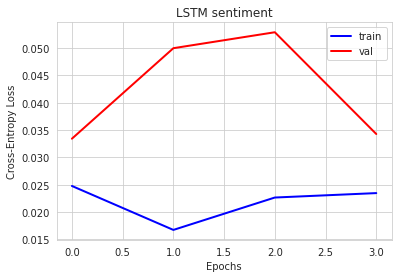

In [ ]:
#generate plots
plt.figure()
plt.plot(history.history['loss'], lw=2.0, color='b', label='train')
plt.plot(history.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('LSTM sentiment')

plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
y_test = test_df[label_names].values
model.evaluate(word_seq_test, y_test)

83/83 [==============================] - 1s 12ms/step - loss: 0.0364 - f1_m: 0.9700 - recall_m: 0.9592 - precision_m: 0.9888


[0.03639185428619385,
 0.9699977040290833,
 0.9592369794845581,
 0.9887549877166748]